# Session 8 - Post-double Selection

## Contents

- [Frisch-Waugh Theorem](#Frisch-Waugh-Theorem)
- [Post-double selection](#Post-double-selection)
- [Double/debiased machine learning](#Double/debiased-machine-learning)


In [1]:
# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Frisch-Waugh theorem

Consider the data $D = \{ x_i, y_i, z_i \}_{i=1}^\infty$ with DGP:

$$
y_i = \alpha x_i + \beta z_i + \varepsilon_i
$$

. The following estimators of $\alpha$ are numerically equivalent (if $[x, z]$ has full rank):

- OLS: $\hat{\alpha}$ from regressing $y$ on $x, z$
- Partialling out: $\tilde{\alpha}$ from regressing $y$ on $\tilde{x}$
- "Double" partialling out: $\bar{\alpha}$ from regressing $\tilde{y}$ on $\tilde{x}$

where the operation of passing to $y, x$ to $\tilde{y}, \tilde{x}$ is called *projection  out $z$*, e.g. $\tilde{x}$ are the residuals from regressing $x$ on $z$.

$$
\tilde{x} = (I - z (z' z)^{-1} z' ) x = (I-P) x = M x
$$

I.e we have done the following:
 1. regress $x$ on $z$
 2. compute $\hat x$
 3. compute the residuals $\tilde x = x - \hat x$
 
We now explore the theorem through simulation.

In [3]:
np.random.seed(1)

# Init
N = 1000
a = 1
b = -.3

# Generate data
x = np.random.uniform(0,1,N).reshape(-1,1)
z = np.random.uniform(0,1,N).reshape(-1,1)
e = np.random.normal(0,1,N).reshape(-1,1)
y = a*x + b*z + e

In [4]:
# Estimate alpha by OLS
xz = np.concatenate([x,z], axis=1)
ols_coeff = inv(xz.T @ xz) @ xz.T @ y
alpha_ols = ols_coeff[0][0]

print('alpha OLS: %.4f (true=%1.0f)' % (alpha_ols, a))

alpha OLS: 1.0928 (true=1)


In [5]:
# Partialling out
x_tilde = (np.eye(N) - z @ inv(z.T @ z) @ z.T ) @ x
alpha_po = inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y

print('alpha partialling out: %.4f (true=%1.0f)' % (alpha_po, a))

alpha partialling out: 1.0928 (true=1)


In [6]:
# "Double" partialling out
y_tilde = (np.eye(N) - z @ inv(z.T @ z) @ z.T ) @ y
alpha_po2 = inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y_tilde

print('alpha double partialling out: %.4f (true=%1.0f)' % (alpha_po2, a))

alpha double partialling out: 1.0928 (true=1)


## Omitted Variable Bias

Consider two separate statistical models. Assume the following **long regression** of interest:

$$
y_i = x_i' \alpha_0+ z_i' \beta_0 + \varepsilon_i
$$

Define the corresponding **short regression** as

$$
  y_i = x_i' \alpha_0 + v_i \quad \text{ with } \quad v_i = z_i' \beta_0 + \varepsilon_i
$$

**OVB Theorem**:
Suppose that the DGP for the long regression corresponds to $\alpha_0$, $\beta_0$. Suppose further that $\mathbb E[x_i] = 0$, $\mathbb E[z_i] = 0$, $\mathbb E[\varepsilon_i |x_i,z_i] = 0$. Then, unless $\beta_0 = 0$ or $z_i$ is orthogonal to $x_i$, the (sole) stochastic regressor $x_i$ is correlated with the error term in the short regression which implies that the OLS estimator of the short regression is inconsistent for $\alpha_0$ due to the omitted variable bias. In particular, one can show that the plim of the OLS estimator of $\hat{\alpha}_{SHORT}$ from the short regression is
$$
\hat{\alpha}_{SHORT} \overset{p}{\to} \frac{Cov(y_i, x_i)}{Var(x_i)} = \alpha_0 + \beta_0 \frac{Cov(z_i, x_i)}{Var(x_i)}
$$

Consider data $D= (y_i, x_i, z_i)_{i=1}^n$, where the true model is:

$$
\begin{aligned}
& y_i = x_i' \alpha_0  + z_i' \beta_0 + \varepsilon_i \\
& x_i = z_i' \gamma_0 + u_i
\end{aligned}
$$

Let's investigate the Omitteb Variable Bias by simulation.

In [7]:
np.random.seed(1)

# Init
N = 1000
a = 1
b = -.3
c = 3

# Generate data
z = np.random.normal(0,1,N).reshape(-1,1)
u = np.random.normal(0,1,N).reshape(-1,1)
x = c*z + u
e = np.random.normal(0,1,N).reshape(-1,1)
y = a*x + b*z + e

In [8]:
# Estimate alpha by OLS
ols_coeff = inv(x.T @ x) @ x.T @ y
alpha_ols = ols_coeff[0][0]

print('alpha OLS: %.4f (true=%1.0f)' % (alpha_ols, a))

alpha OLS: 0.8932 (true=1)


In our case the expected bias is:

$$
Bias = \beta_0 \frac{Cov(z_i, x_i)}{Var(x_i)} = \\
= \beta_0 \frac{Cov(z_i' \gamma_0 + u_i, x_i)}{Var(z_i' \gamma_0 + u_i)} = \\
= \beta_0 \frac{\gamma_0 Var(z_i)}{\gamma_0^2 Var(z_i) + Var(u_i)} = \\
= b \frac{c}{c^2 + 1}
$$

In [9]:
# Expected bias
bias = alpha_ols - a
exp_bias = b * c / (c**2 + 1)

print('Bias: %.4f (expected=%.4f)' % (bias, exp_bias))

Bias: -0.1068 (expected=-0.0900)


## Pre-test bias

Consider data $D= (y_i, x_i, z_i)_{i=1}^n$, where the true model is:

$$
\begin{aligned}
& y_i = x_i' \alpha_0  + z_i' \beta_0 + \varepsilon_i \\
& x_i = z_i' \gamma_0 + u_i
\end{aligned}
$$

Where $x_i$ is the variable of interest (we want to make inference on $\alpha_0$) and $z_i$ is a high dimensional set of control variables. 

From now on, we will work under the following assumptions:

- $\dim(x_i)=1$ for all $n$
- $\beta_0$ uniformely bounded in $n$
- Strict exogeneity: $\mathbb E[\varepsilon_i | x_i, z_i] = 0$ and $\mathbb E[u_i | z_i] = 0$
- $\beta_0$ and $\gamma_0$ have dimension (and hence value) that depend on $n$

Pre-Testing procedure:

1. Regress $y_i$ on $x_i$ and $z_i$
2. For each $j = 1, ..., p = \dim(z_i)$ calculate a test statistic $t_j$
3. Let $\hat{T} = \{ j: |t_j| > C > 0 \}$ for some constant $C$ (set of statistically significant coefficients).
4. Re-run the new "model" using $(x_i, z_{\hat{T},i})$ (i.e. using the selected covariates with statistically significant coefficients).
5. Perform statistical inference (i.e. confidence intervals and hypothesis tests) as if no model selection had been done.

Pre-testing leads to incorrect inference.

In [13]:
# Pre-testing code
def pre_testing(a, b, c, N, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        z = np.random.normal(0,1,N).reshape(-1,1)
        u = np.random.normal(0,1,N).reshape(-1,1)
        x = c*z + u
        e = np.random.normal(0,1,N).reshape(-1,1)
        y = a*x + b*z + e
        
        # Compute coefficients
        xz = np.concatenate([x,z], axis=1)
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance test on beta_hat
        beta_hat = (inv(xz.T @ xz) @ xz.T @ y)[1][0]
        residuals = y - alpha['Long'][i]*x - beta_hat*z
        sigma_hat = np.var(residuals)
        beta_std = np.sqrt( inv(xz.T @ xz)[1,1] * sigma_hat )
        t = beta_hat/beta_std
        
        # Select specification based on test
        if np.abs(t)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
    
    return alpha

In [14]:
# Get pre_test alpha
alpha = pre_testing(a, b, c, N)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

Mean alpha Long = 0.9994
Mean alpha Short = 0.9095
Mean alpha Pre-test = 0.9925


The pre-testing coefficient is much less biased than the short regression one. But it's still biased.

In [15]:
def plot_alpha(alpha, a):
    
    fig = plt.figure(figsize=(17,6))

    # Plot distributions
    x_max = np.max([np.max(np.abs(x-a)) for x in alpha.values()])

    # All axes
    for i, key in enumerate(alpha.keys()):
        
        # Reshape exisiting subplots
        k = len(fig.axes)
        for i in range(k):
            fig.axes[i].change_geometry(1, k+1, i+1)
            
        # Add new plot
        ax = fig.add_subplot(1, k+1, k+1)
        ax.hist(alpha[key], bins=30)
        ax.set_title(key)
        ax.set_xlim([a-x_max, a+x_max])
        ax.axvline(a, c='r', ls='--')
        legend_text = [r'$\alpha_0=%.0f$' % a, r'$\hat \alpha=%.4f$' % np.mean(alpha[key])]
        ax.legend(legend_text, loc='upper right')

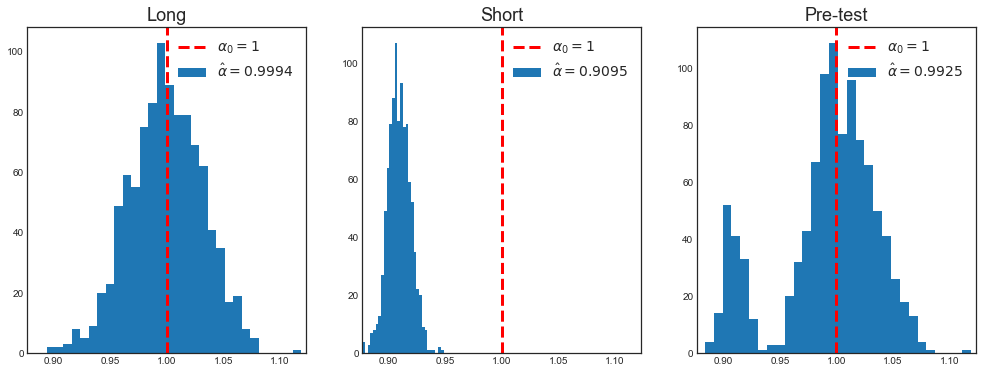

In [16]:
# Plot
plot_alpha(alpha, a)

When is pre-testing a problem? When the magnitude of $\beta_0$ is small with respect to the sample size

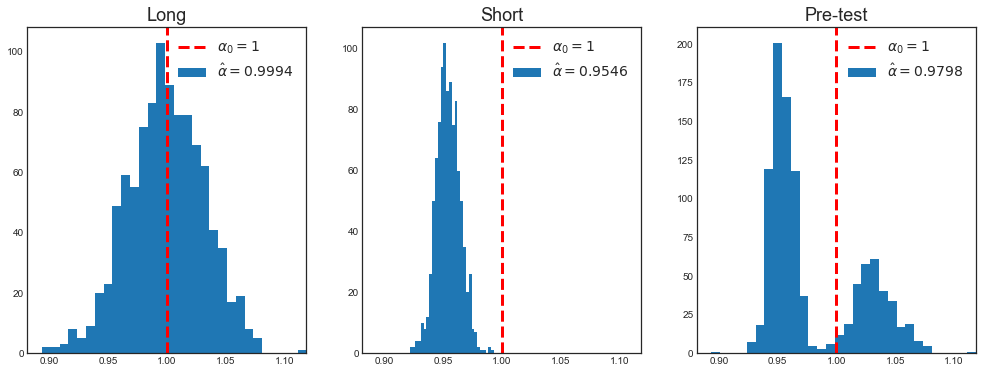

In [17]:
# With a smaller b
b_small = b/2

# Get pre_test alpha
alpha = pre_testing(a, b_small, c, N)

# Plot
plot_alpha(alpha, a)

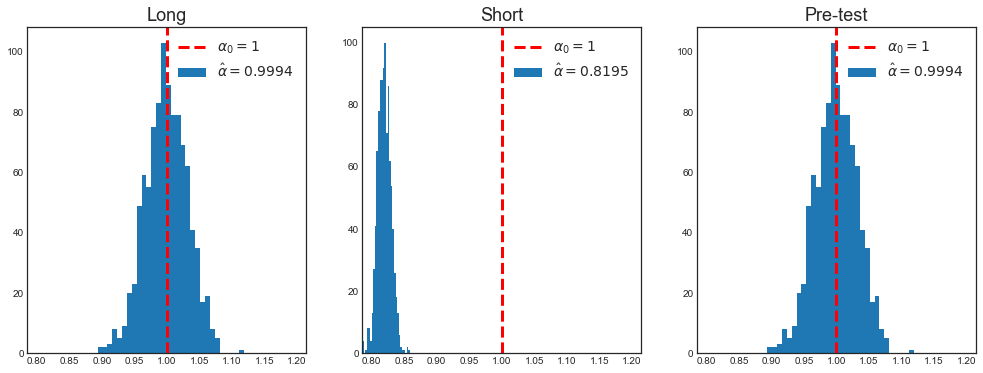

In [18]:
# With a bigger b
b_big = b*2

# Get pre_test alpha
alpha = pre_testing(a, b_big, c, N)

# Plot
plot_alpha(alpha, a)

What does "*big with respect to the sample size*" mean?

Let's have a look at a process where the coefficient does not depend on the sample size.

In [19]:
# Case 1: beta that does not vary with sample size
N_sequence = [100,300,1000,3000]
alpha = {}

# Get sequence
for k, n in enumerate(N_sequence):
    label = 'N = %.0f' % n
    alpha[label] = pre_testing(a, b, c, n)['Pre-test']
    print('Mean with n=%.0f: %.4f' % (n, np.mean(alpha[label])))

Mean with n=100: 0.9442
Mean with n=300: 0.9635
Mean with n=1000: 0.9925
Mean with n=3000: 0.9989


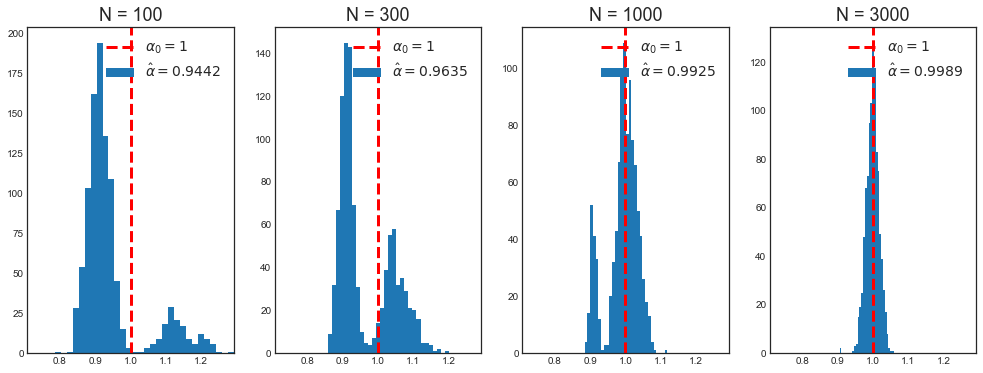

In [20]:
# Plot
plot_alpha(alpha, a)

Now suppose the coefficient depends on the sample size.

In [21]:
# Case 2: beta that does not vary with sample size
beta =  b * 30 / np.sqrt(N_sequence)

# Get sequence
alpha = {}
for k, n in enumerate(N_sequence):
    label = 'N = %.0f' % n
    alpha[label] = pre_testing(a, beta[k], c, n)['Pre-test']
    print('Mean with n=%.0f: %.4f' % (n, np.mean(alpha[label])))

Mean with n=100: 0.9703
Mean with n=300: 0.9838
Mean with n=1000: 0.9914
Mean with n=3000: 0.9947


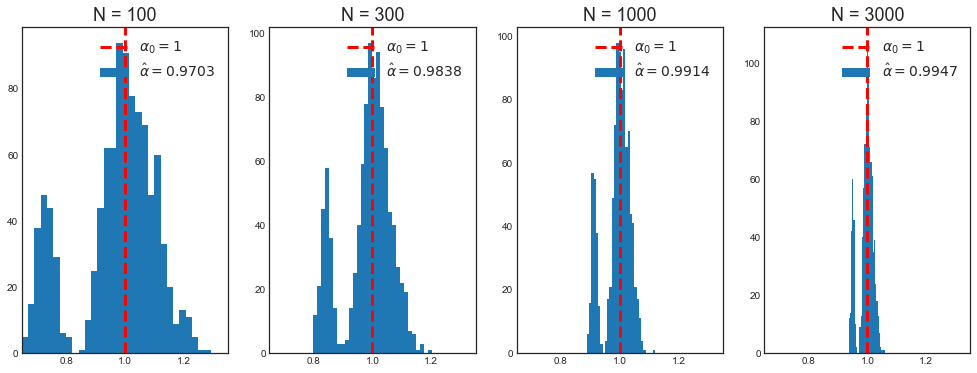

In [22]:
# Plot
plot_alpha(alpha, a)

Post-double selection solves this problem

## Post-double selection

Consider again data $D= (y_i, x_i, z_i)_{i=1}^n$, where the true model is:
$$
\begin{aligned}
& y_i = x_i' \alpha_0  + z_i' \beta_0 + \varepsilon_i \\
& x_i = z_i' \gamma_0 + u_i
\end{aligned}
$$

We would like to guard against pretest bias if possible, in order to handle high dimensional models. A good pathway towards motivating procedures which guard against pretest bias is a discussion of classical partitioned regression.

Consider a regression $y_i$ on $x_i$ and $z_i$. $x_i$ is the 1-dimensional variable of interest, $z_i$ is a high-dimensional set of control variables. We have the following procedure:

1. **First Stage** selection: lasso $x_i$ on $z_i$. Let the selected variables be collected in the set $S_{FS} \subseteq z_i$
2. **Reduced Form** selection: lasso $y_i$ on $z_i$. Let the selected variables be collected in the set $S_{RF} \subseteq z_i$
3. Regress $y_i$ on $x_i$ and $S_{FS} \cup S_{RF}$


**Theorem**:
Let $\{P^n\}$ be a sequence of data-generating processes for $D_n = (y_i, x_i, z_i)^n_{i=1} \in (\mathbb R \times \mathbb R \times \mathbb R^p) ^n$ where $p$ depends on $n$. For each $n$, the data are iid with $yi =  x_i'\alpha_0^{(n)} + z_i' \beta_0^{(n)} + \varepsilon_i$ and $x_i = z_i' \gamma_0^{(n)} + u_i$ where $\mathbb E[\varepsilon_i | x_i,z_i] = 0$ and $\mathbb E[u_i|z_i] = 0$. The sparsity of the vectors  $\beta_0^{(n)}$, $\gamma_0^{(n)}$ is controlled by $|| \beta_0^{(n)} ||_0 \leq s$ with $s^2 (\log p)^2/n \to 0$. Suppose that additional regularity conditions on the model selection procedures and moments of the random variables $y_i$ , $x_i$ , $z_i$ as documented in Belloni et al. (2014). Then the confidence intervals, CI, from the post double selection procedure are uniformly valid. That is, for any confidence level $\xi \in (0, 1)$
$$
		\Pr(\alpha_0 \in CI) \to 1- \xi
$$

In order to have valid confidence intervals you want their bias to be negligibly. Since
$$
  CI = \left[ \hat{\alpha} \pm \frac{1.96 \cdot \hat{\sigma}}{\sqrt{n}} \right]
$$

If the bias is $o \left( \frac{1}{\sqrt{n}} \right)$ then there is no problem since it is asymptotically negligible w.r.t. the magnitude of the confidence interval. If however the the bias is $O \left( \frac{1}{\sqrt{n}} \right)$ then it has the same magnitude of the confidence interval and it does not asymptotically vanish. 

The idea of the proof is to use partitioned regression. An alternative way to think about the argument is: bound the omitted variables bias. Omitted variable bias comes from the product of 2 quantities related to the omitted variable:

1. Its partial correlation with the outcome, and
2. Its partial correlation with the variable of interest.

If both those partial correlations are $O( \sqrt{\log p/n})$, then the omitted variables bias is $(s \times O( \sqrt{\log p/n})^2 = o \left( \frac{1}{\sqrt{n}} \right)$, provided $s^2 (\log p)^2/n \to 0$. Relative to the $ \frac{1}{\sqrt{n}} $ convergence rate, the omitted variables bias is negligible. 

In our omitted variable bias case, we want $| \beta_0 \gamma_0 | = o \left( \frac{1}{\sqrt{n}} \right)$.  Post-double selection guarantees that 

- *Reduced form* selection (pre-testing): any "missing" variable has $|\beta_{0j}| \leq \frac{c}{\sqrt{n}}$
- *First stage* selection (additional): any "missing" variable has $|\gamma_{0j}| \leq \frac{c}{\sqrt{n}}$


As a consequence, as long as the number of omitted variables is finite, the omitted variable bias is 
$$
	OVB(\alpha) = |\beta_{0j}| \cdot|\gamma_{0j}| \leq \frac{c}{\sqrt{n}} \cdot \frac{c}{\sqrt{n}} = \frac{c^2}{n} = o \left(\frac{1}{\sqrt{n}}\right)
$$

In [31]:
# Pre-testing code
def post_double_selection(a, b, c, N, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1)),
            'Post-double': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        z = np.random.normal(0,1,N).reshape(-1,1)
        u = np.random.normal(0,1,N).reshape(-1,1)
        x = c*z + u
        e = np.random.normal(0,1,N).reshape(-1,1)
        y = a*x + b*z + e
        
        # Compute coefficients
        xz = np.concatenate([x,z], axis=1)
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance test on z
        beta_hat = (inv(xz.T @ xz) @ xz.T @ y)[1][0]
        residuals = y - alpha['Long'][i]*x - beta_hat*z
        sigma2_hat = np.var(residuals)
        beta_std = np.sqrt( inv(xz.T @ xz)[1,1] * sigma2_hat )
        t1 = beta_hat/beta_std
        
        # Compute "first stage" test on z
        gamma_hat = inv(z.T @ z) @ z.T @ x
        residuals = x - gamma_hat*z
        sigma2_hat = np.var(residuals)
        gamma_std = np.sqrt( inv(x.T @ x) * sigma2_hat )
        t2 = gamma_hat/gamma_std
        
        # Select specification based on test
        if np.abs(t1)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
            
        # Select specification based on test
        if np.abs(t1)>1.96 or np.abs(t2)>1.96:
            alpha['Post-double'][i] = alpha['Long'][i]
        else:
            alpha['Post-double'][i] = alpha['Short'][i]
    
    return alpha

In [32]:
# Get pre_test alpha
alpha = post_double_selection(a, b, c, N)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

Mean alpha Long = 0.9994
Mean alpha Short = 0.9095
Mean alpha Pre-test = 0.9925
Mean alpha Post-double = 0.9994


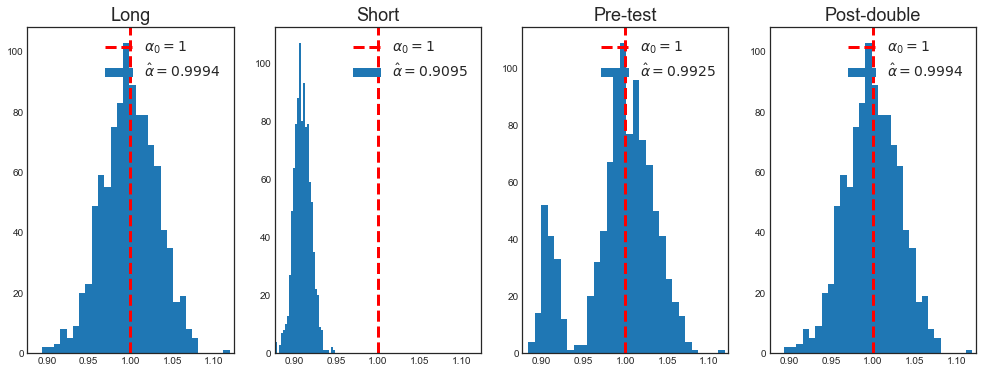

In [33]:
# Plot
plot_alpha(alpha, a)

### Application to Effect of Legalized Abortion on Crime

## Double/debiased machine learning

This section is taken from [Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2018). "*Double/debiased machine learning for treatment and structural parameters*"](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097).

Consider the following partially linear model

$$
y = \beta_0 D + g_0(X) + \varepsilon \\
D = m_0(X) + u
$$

where $y$ is the outcome variable, $D$ is the treatment to interest and $X$ is a potentially high-dimensional set of controls.

#### Naive approach

A naive approach to estimation of $\beta_0$ using ML methods would be, for example, to construct a sophisticated ML estimator $\beta_0 D + g_0(X)$ for learning the regression function $\beta_0 D$ + $g_0(X)$.

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0(X)$
3. Use the main sample to estimate the residualized OLS estimator

$$
\hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} D_{i}^{2}\right)^{-1} \frac{1}{n} \sum_{i \in I} D_{i}\left(Y_{i}-\hat{g}_{0}\left(X_{i}\right)\right)
$$

This estimator is going to have two problems:

1. Slow rate of convergence, i.e. slower than $n^{1/2}$
2. It will be biased

#### Orthogonalization

Now consider a second construction that employs an orthogonalized formulation obtained by directly partialling out the effect of $X$ from $D$ to obtain the orthogonalized regressor $V = D − m_0(X)$.

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0(X)$
3. Use the auxiliary sample to estimate $\hat m_0(X)$
4. Build the orthogonalized component of $X$: $\hat u = D - \hat m_0(X)$
5. Use the main sample to estimate the double-residualized OLS estimator

$$
\hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} \hat u_i D_{i} \right)^{-1} \frac{1}{n} \sum_{i \in I} \hat u_i \left(Y_{i}-\hat{g}_{0}\left(X_{i}\right)\right)
$$

The estimator is unbiased but still has a lower rate of convergence because of sample splitting. The proble is solved by inverting the split sample, re-estimating the coefficient and averaging the two estimates. Note that this procedure is valid since the two estimates are independent by the sample splitting procedure.

### Application to AJR02

In this section we are going to replicate 6.3 of the "*Double/debiased machine learning*" paper based on [Acemoglu, Johnson, Robinson (2002), "*The Colonial Origins of Comparative Development*"](https://economics.mit.edu/files/4123).

We first load the dataset

In [41]:
# Load Acemoglu Johnson Robinson Dataset
df = pd.read_csv('data/AJR02.csv')
df = df.loc[df['baseco']==1,:]
df = df[['avexpr','logpgp95', 'lat_abst', 'asia', 'africa', 'other','logem4']]
df = df.reset_index()

In [42]:
df.head()

,index,avexpr,logpgp95,lat_abst,asia,africa,other,logem4
0,1,5.363637,7.770645,0.136667,0,1,0,5.634790
1,3,6.386363,9.133459,0.377778,0,0,0,4.232656
2,5,9.318182,9.897972,0.300000,0,0,1,2.145931
3,11,4.454546,6.845880,0.144444,0,1,0,5.634790
4,12,5.136363,6.877296,0.266667,1,0,0,4.268438


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     64 non-null     int64  
 1   avexpr    64 non-null     float64
 2   logpgp95  64 non-null     float64
 3   lat_abst  64 non-null     float64
 4   asia      64 non-null     int64  
 5   africa    64 non-null     int64  
 6   other     64 non-null     int64  
 7   logem4    64 non-null     float64
dtypes: float64(4), int64(4)
memory usage: 4.1 KB


In their paper, AJR note that their IV strategy will be invalidated if other factors are also highly persistent and related to the development of institutions within a country and to the country’s GDP. A leading candidate for such a factor, as they discuss, is geography. AJR address this by assuming that the confounding effect of geography is adequately captured by a linear term in distance from the equator and a set of continent dummy variables. 

They inclue their results in table 2.

In [44]:
# Add constant term to dataset
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = df[['const', 'avexpr']]
X2 = df[['const', 'avexpr', 'lat_abst']]
X3 = df[['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']]
y = df['logpgp95']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(y, X1, missing='drop').fit()
reg2 = sm.OLS(y, X2, missing='drop').fit()
reg3 = sm.OLS(y, X3, missing='drop').fit()

In [45]:
info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1','Model 3','Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const','avexpr','lat_abst','asia','africa'])

results_table

,Model 1,Model 3,Model 4
const,4.66***,4.73***,5.74***
,(0.41),(0.40),(0.40)
avexpr,0.52***,0.47***,0.40***
,(0.06),(0.06),(0.06)
lat_abst,,1.58**,0.88
,,(0.71),(0.63)
asia,,,-0.58**
,,,(0.23)
africa,,,-0.88***
,,,(0.17)


Using DML allows us to relax this assumption and to replace it by a weaker assumption that geography can be sufficiently controlled by an unknown function of distance from the equator and continent dummies, which can be learned by ML methods.

In particular, our framework is

$$
{logpgp95} = \beta_0 \times {avexpr} + g_0({geography}) + \varepsilon \\
{avexpr} = m_0({geography}) + u
$$

So that the double/debiased machine learning procedure is

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0({geography})$ 
3. Use the auxiliary sample to estimate $\hat m_0({geography})$
4. Build the orthogonalized component of ${geography}$: $\hat u = {avexpr} - \hat m_0({geography})$
5. Use the main sample to estimate the double-residualized OLS estimator

$$
\hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} \hat u_i \times {avexpr}_{i} \right)^{-1} \frac{1}{n} \sum_{i \in I} \hat u_i \times \left({logpgp95}_{i}-\hat{g}_{0}\left({geography}_{i}\right)\right)
$$

In [46]:
# Generate variables
D = df['avexpr'].values.reshape(-1,1)
X = df[['const', 'lat_abst', 'asia', 'africa', 'other']].values.reshape(-1,5)
y = df['logpgp95'].values.reshape(-1,1)
Z = df[['const', 'lat_abst', 'asia', 'africa', 'other','logem4']].values.reshape(-1,6)

Now we write down the whole procedure.

In [152]:
def estimate_beta(algorithm, alg_name, D, X, y, Z, size=0.5, verbose=False):
    
    # Split sample
    D_main, D_aux, X_main, X_aux, y_main, y_aux, Z_main, Z_aux = train_test_split(D, X, y, Z, test_size=size)
    
    # Residualize y on D
    y_resid = y_aux - D_aux @ inv(D_aux.T @ D_aux) @ D_aux.T @ y_aux
    alg_fitted = algorithm.fit(X=X_aux, y=y_resid.ravel())
    
    # Estimate g0
    g0 = alg_fitted.predict(X_main).reshape(-1,1)
    alg_fitted = algorithm.fit(X=Z_aux, y=D_aux.ravel())
    
    # Estimate m0
    m0 = algorithm.predict(Z_main).reshape(-1,1)
    
    # Build u_hat
    u_hat = D_main - m0
    
    # Estimate beta
    beta = inv(u_hat.T @ D_main) @ u_hat.T @ (y_main - g0_tree)
    if verbose:
        print('%s : %.4f' % (alg_name, beta[0][0]))
    return beta[0][0]

We now repeat the same process with different algorithms. In particular, we consider:

1. Lasso
2. Regression Trees
3. Random Forest
4. Boosting

In [128]:
# List all algorithms
algorithms = {'Lasso   ': Lasso(), 
              'Tree    ': DecisionTreeRegressor(), 
              'Forest  ': RandomForestRegressor(),
              'Boosting': GradientBoostingRegressor()}

In [153]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    estimate_beta(algorithm, alg_name, D, X, y, Z, verbose=True)

Lasso    : 0.9438
Tree     : 0.6737
Forest   : 0.7397
Boosting : 1.0306


In [183]:
# Repeat 100 times
def estimate_beta_n(algorithms, n, D, X, y, Z):
    
    # Init
    betas = dict.fromkeys(algorithms.keys(), [])
    
    # Iterate n times
    for i in range(n):
    
        # Loop over algorithms
        for alg_name, algorithm in algoritms.items():
            beta = estimate_beta(algorithm, alg_name, D, X, y, Z)
            betas[alg_name] = np.append(betas[alg_name], beta)
    
    # Print coefficients and standard errors
    for alg_name in algorithms.keys():
        print('%s : %.4f (%.4f)' % (alg_name, np.mean(betas[alg_name]), np.std(betas[alg_name])))

In [184]:
estimate_beta_n(algorithms, 10, D, X, y, Z)

Lasso    : 0.3898 (1.2581)
Tree     : 1.9663 (4.4479)
Forest   : 6.8110 (12.8342)
Boosting : -1.8580 (7.1255)
